In [1]:
from typing import List
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader
import torch
import pandas as pd
import numpy as np
import flwr as fl
from fl_preprocessing import preprocessing
from sklearn.metrics import mean_squared_error
from fl_model import get_model
from myconstants import *

In [2]:
from fl_test import load_data
trainloaders, testloaders, nums_examples, nums_features, X_tests, scalers = load_data(batch_size=BATCH_SIZE)
X_train_arr, X_test_arr, y_train_arr, y_test_arr, X_test, scaler = preprocessing('102.csv')

/Library/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Library/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


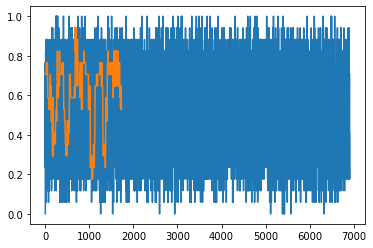

In [5]:
import matplotlib.pyplot as plt
plt.plot(y_train_arr[:,0])
plt.plot(y_test_arr[:,0])

In [6]:
timeseries = np.hstack((y_train_arr[:,0],y_test_arr[:,0]))
len(timeseries)

/Library/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


8635

In [7]:
#convert to Tensor:
X_train = torch.Tensor(X_train_arr).to(DEVICE)
y_train = torch.Tensor(y_train_arr).to(DEVICE)
X_test = torch.Tensor(X_test_arr).to(DEVICE)
y_test = torch.Tensor(y_test_arr).to(DEVICE)

In [ ]:
from fl_test import train, test, get_parameters
net = get_model(MODEL, MODEL_PARAMS).to(DEVICE)
losses=train(net,trainloaders[0],epochs=50)
loss, rmse = test(net, testloaders[0], X_tests[0], scalers[0])
print("loss ", loss)
print("rmse ", rmse)

In [8]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=9, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = trainloaders[0]

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1457, test RMSE 0.1003


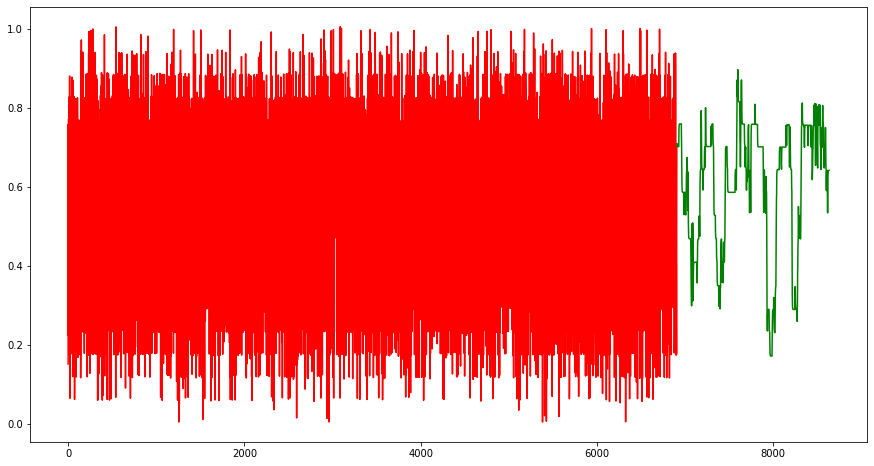

In [12]:
import matplotlib.pyplot as plt
lookback, train_size=0,len(X_train)
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = model(X_train)[:, -1]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]
# plot
plt.figure(figsize=(15,8))
#plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

/Library/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


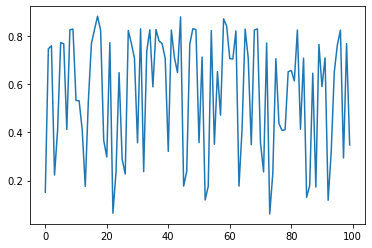

In [25]:
plt.plot(train_plot[0:100])